### 現状で精度の出ているパラメーターで各患者ごとの精度を見る
- パッチのサイズ：100×100, slide = 10

- テストデータ・学習データはアンダーサンプリングで、【癌あり：癌なし】= 【１：１】 になるようにしている

- 学習データの50%をvalidation_dataとして使用する（以前は10%だったがそれでは精度が出なかった）

- batch_size：64, epoch：20 

In [1]:
import cv2
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

/Users/daichisato/anaconda/envs/lily/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(12345)

In [3]:
import keras
from collections import Counter
from keras import backend as K
from keras import models
from keras.utils import np_utils
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
from data_making import mk_data

Using TensorFlow backend.


### データの作成

In [4]:
def cut_window_by_coordinate(img, left_x, upper_y, window_width, window_height):
    """ 
    座標を指定することで、画像から矩形領域をカットする関数
    left_x : 左上のx座標
    upper_y : 左上のy座標
    window_width : 矩形の幅a
    window_height : 矩形の高さ
    """
    # 窓画像の左上座標
    x, y = left_x, upper_y
    # 窓画像の幅・高さ
    w, h = window_width, window_height
    # 入力画像から窓画像を切り取り
    roi = img[y:y+h, x:x+w]    
    return roi

In [5]:
# それぞれの画像について腫瘍情報のテーブルを作る
#UT007に関してはもう一度みる必要あり
pic_info = pd.DataFrame({
                'patient_id' :        ['UT001', 'UT001', 'UT001', 'UT010', 'UT010', 'UT010',  'UT010', 'UT003', 'UT003', 'UT003', 'UT007', 'UT007', 'UT007', 'UT008', 'UT008', 'UT008', 'UT009', 'UT009', 'UT009','UT011','UT011','UT011'],
                'patient_sub_height': [  '100',   '200',   '300',   '900',  '1000',  '1100',   '1200',  '1300',  '1400',  '1500',   '700',   '800',   '900',   '600',   '700',   '800',  '1500',  '1600',  '1700',  '600',  '700',  '800'],
                'patient_sub_speed':  [ '1480',  '1480',  '1480',  '1510',  '1510',  '1510',   '1510',  '1480',  '1480',  '1480',  '1523',  '1523',  '1523',  '1521',  '1521',  '1521',  '1518',  '1518',  '1518', '1523', '1523', '1523'],
                'tumor_left_x' :      [    195,     201,     198,     310,     310,     310,     310,      295,     290,    290,      180,     200,     195,     200,     200,     200,     132,     132,     127,    170,   175,     172],
                'tumor_upper_y' :     [    205,     208,     200,     225,     225,     225,     230,      300,     298,    300,      230,     250,     240,     220,     220,     220,     270,     270,     270,    245,   250,     253],
                'tumor_width' :       [     50,      50,      50,      70,      50,      45,      45,       50,      50,     50,       80,      60,      70,      70,      70,      70,      50,      50,      50,     55,    55,      45],
                'tumor_height' :      [     45,      45,      45,      45,      70,      50,      50,       35,      30,     40,       80,      60,      70,      40,      40,      40,      55,      55,      55,     55,    55,      45],
                'default_left_x' :    [    100,     100,     100,     150,    150,      150,     150,      100,     100,    100,      100,     100,     100,     100,     100,     100,     100,     100,      100,    100,   100,    100],
                'default_upper_y' :   [    100,     100,     100,     100,    100,      100,     100,      100,     100,    100,      200,     200,     200,     100,     100,     100,     100,     100,      100,    100,   100,    100],
                'max_left_x' :        [    340,     340,     340,     340,    340,      340,     340,      340,     340,    340,      220,     220,     220,     340,     340,     340,     340,     340,      340,    250,   250,    250],
                'max_upper_y' :       [    340,     340,     340,     340,    340,      340,     340,      340,     340,    340,      280,     280,     280,     240,     340,     340,     340,     340,      340,    300,   300,    300],
                'file_path' : ['./data/all_data/tumor/P_UT001_20161226_153444_100_speed1480_GCF010_comp8.bmp',
                               './data/all_data/tumor/P_UT001_20161226_153500_200_speed1480_GCF010_comp8.bmp',
                               './data/all_data/tumor/P_UT001_20161226_153514_300_speed1480_GCF010_comp8.bmp',
                               './data/all_data/tumor/N_UT010_20170428_141903_900_speed1510_GCF10_comp8_max02.bmp',
                               './data/all_data/tumor/N_UT010_20170428_141918_1000_speed1510_GCF10_comp8_max02.bmp',
                               './data/all_data/tumor/N_UT010_20170428_141932_1100_speed1510_GCF10_comp8_max02.bmp',
                               './data/all_data/tumor/N_UT010_20170428_141946_1200_speed1510_GCF10_comp8_max02.bmp',
                               './data/all_data/tumor/UT003_20170120_155150_1300_speed1480_GCF10_comp8.bmp',
                               './data/all_data/tumor/UT003_20170120_155205_1400_speed1480_GCF10_comp8.bmp',
                               './data/all_data/tumor/UT003_20170120_155219_1500_speed1480_GCF10_comp8.bmp',
                               './data/all_data/tumor/UT007_20170303_120722_700_speed1523.985_gcf10_comp8_1490_binarySpeed.bmp',
                               './data/all_data/tumor/UT007_20170303_120736_800_speed1523.985_gcf10_comp8_1490_binarySpeed.bmp',
                               './data/all_data/tumor/UT007_20170303_120750_900_speed1523.985_gcf10_comp8_1490_binarySpeed.bmp',
                               './data/all_data/tumor/N_UT_008_20170407_144338_600_speed1521.935_gcf10_comp8_1400_binarySpeed.bmp',
                               './data/all_data/tumor/N_UT_008_20170407_144352_700_speed1521.935_gcf10_comp8_1400_binarySpeed.bmp',
                               './data/all_data/tumor/N_UT_008_20170407_144407_800_speed1521.935_gcf10_comp8_1400_binarySpeed.bmp',
                               './data/all_data/tumor/UT009_20170421_135409_1500_speed1518.414_gcf10_comp8_1395_binarySpeed.bmp',
                               './data/all_data/tumor/UT009_20170421_135424_1600_speed1518.414_gcf10_comp8_1395_binarySpeed.bmp',
                               './data/all_data/tumor/UT009_20170421_135438_1700_speed1518.414_gcf10_comp8_1395_binarySpeed.bmp',
                               './data/all_data/tumor/UT011_20170512_141428_600_speed1523.434_gcf10_comp8_1460_binarySpeed.bmp',
                               './data/all_data/tumor/UT011_20170512_141441_700_speed1523.434_gcf10_comp8_1460_binarySpeed.bmp',
                               './data/all_data/tumor/UT011_20170512_141455_800_speed1523.434_gcf10_comp8_1460_binarySpeed.bmp',]
                }, index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [6]:
j = 0
X = []

patch = []
p_id = []
label = []
x_y_label = []

sample_size = len(pic_info)  # 2以上である必要あり

# パッチのサイズの情報
window_width = 100
window_height = 100   
slide_width = 10

for j in range(0, sample_size, 1):

    patient_id = pic_info['patient_id'][j]
    tumor_left_x = pic_info['tumor_left_x'][j]
    tumor_upper_y = pic_info['tumor_upper_y'][j]
    tumor_width = pic_info['tumor_width'][j]
    tumor_height = pic_info['tumor_height'][j]
    default_left_x = pic_info['default_left_x'][j]
    default_upper_y = pic_info['default_upper_y'][j]
    max_left_x = pic_info['max_left_x'][j]
    max_upper_y = pic_info['max_upper_y'][j]
    file_path = pic_info['file_path'][j]
    
    img = cv2.imread(file_path)       

    # 写真の中の(100, 100) から (440, 440)までの間でパッチを作る
    # パッチの大きさは100 * 100にする
    # スライド幅は20ずつにする
    # sliding windowにより作られるパッチの数は (340 - 100) / 20 * (340 - 100) / 20 = 144個
    # それが5つぶんで 144 * 5 = 720個
            
    i = 0

    for left_x in range(default_left_x, max_left_x, slide_width):
        for upper_y in range(default_upper_y, max_upper_y, slide_width):
            img_patch = cut_window_by_coordinate(img, left_x, upper_y, window_width, window_height)
            
            X.append(img_to_array(img_patch/255.0))
            
            # 癌が含まれているかの判定 完全に領域を含んでいる場合のみ検出する
            if tumor_left_x >= left_x and tumor_left_x + tumor_width <= left_x + window_width and tumor_upper_y >= upper_y and tumor_upper_y + tumor_height <= upper_y + window_height:
                contains_tumor = 1 
            else: contains_tumor = 0
            
            # 角フラグを立てる
            if left_x == default_left_x or left_x == max_left_x - slide_width:
                corner_flag = 1
            else: corner_flag = 0
            
            # patch_idの付与 一応
            patch_id = patient_id + str(left_x) + str(upper_y)      
            
            #画像とlabelの対応を確実に行う
            x_y_set = (img_to_array(img_patch/255.0), contains_tumor, patient_id, patch_id)
            
            p_id.append(patient_id)
            patch.append(patch_id)
            label.append(contains_tumor)
            x_y_label.append(x_y_set)
            
            i += 1

### 前処理用の関数

In [7]:
def mk_data(patient):
    train_cancer=[]
    train_not_cancer=[]
    test_cancer=[]
    test_not_cancer=[]

    for i in range(len(x_y_label)):
        if x_y_label[i][1] == 0 and x_y_label[i][2] != patient :
            train_not_cancer.append(x_y_label[i])
        elif x_y_label[i][1] == 1 and x_y_label[i][2] != patient :
            train_cancer.append(x_y_label[i])
        elif x_y_label[i][1] == 0 and x_y_label[i][2] == patient :
            test_not_cancer.append(x_y_label[i])
        elif x_y_label[i][1] == 1 and x_y_label[i][2] == patient :
            test_cancer.append(x_y_label[i])

    #ラベルの比率合わせ
    train_length_min = min([len(train_cancer), len(train_not_cancer)])
    test_length_min = min([len(test_cancer), len(test_not_cancer)])

    random.seed(12345)

    train_cancer = random.sample(train_cancer, train_length_min)
    train_not_cancer = random.sample(train_not_cancer, train_length_min)
    test_cancer = random.sample(test_cancer, test_length_min)
    test_not_cancer = random.sample(test_not_cancer, test_length_min) 

    train_cancer.extend(train_not_cancer)
    test_cancer.extend(test_not_cancer)
    
    X_train, Y_train, _, _, = list(zip(*train_cancer))
    X_test, Y_test, _, _, = list(zip(*test_cancer))

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
                                                          
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    from keras.utils.np_utils import to_categorical

    x_train = np.array(X_train).astype('float32')
    y_train = to_categorical(Y_train, 2)

    x_test = np.array(X_test).astype('float32')
    y_test = to_categorical(Y_test, 2)
    
    img_rows, img_cols = 100, 100
    
    # shapeの調整
    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
        input_shape = (img_rows, img_cols, 1)
        
    #validation_dataの作成(train_dataの0.5割をvalidationとしている)
    val_x_train, val_x_test, val_y_train, val_y_test = train_test_split(x_train, y_train, test_size=0.5, random_state=12345)
    
    return Y_test, X_train, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test

### 現在のモデル
- DropoutやBatch_Normalization は入れると精度が下がってしまう・・・
- validation_lossが下がらなかったearly_stoppingするようにしている

#### random_seedは設定しているが, 施行ごとに結果が変わってしまう・・・
（Kerasにはseedのオプションはないみたいで、おそらくAdamの中で何か起きている?）

In [8]:
def cnn_model (n_filter, n_filter2, n_filter3, size_filter, n_hidden, n_label, X_train):
    model = Sequential()

    model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                     input_shape=X_train.shape[1:], activation = 'relu'))
    model.add(Conv2D(n_filter,(size_filter, size_filter), activation = 'relu'))
    #model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
    #model.add(Dropout(0.25))

    model.add(Conv2D(n_filter2, (size_filter, size_filter), padding='same', activation = 'relu'))
    #model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(n_filter2, (size_filter, size_filter), activation = 'relu'))
    #model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
    #model.add(Dropout(0.25))

    model.add(Conv2D(n_filter3, (size_filter, size_filter), padding='same', activation = 'relu'))

    #model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(n_filter3, (size_filter, size_filter), activation = 'relu'))
    #model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
    model.add(Flatten())
    model.add(Dense(n_hidden))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(n_label))       # クラスは2個
    model.add(Activation('sigmoid'))
    
    return model 

In [9]:
def keras_cnn_fit(loss, optimizer, batch, epoch, Y_test, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test):
    
    x_test = x_test
    Y_test = Y_test
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    #　Tensor Boardのcallbackを作成
    from keras.callbacks import TensorBoard
    tbcb = TensorBoard(log_dir = './graph',
                     histogram_freq = 0, write_graph = True)

    # historyに学習履歴を取得
    es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

    history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                       validation_data = (val_x_test, val_y_test), verbose=1,
                       callbacks = [es_cb])


    # モデルの保存
    #from keras.models import model_from_json
    #model_json=model.to_json()
    #with open("model.json",mode='w') as f:
    #    f.write(model_json)
    
    # 学習済みの重みを保存
    #model.save_weights("weights.hdf5")

    # 学習履歴を保存
    #import pickle
    #with open("history.pickle",mode='wb') as f:
    #    pickle.dump(history.history,f)
    
    score = model.evaluate(x_test, y_test, verbose=0)

    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    #loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    classes = model.predict_classes(x_test)

    confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
    test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
    print(confmat)
    print('accuracy : ', accuracy_score(Y_test, classes))
    print('recall: ', recall_score(Y_test, classes))

    return test_seikai_label, x_test, Y_test, classes

In [10]:
def check_misclassification_image(test_seikai_label, x_test, Y_test, classes):
    diff = test_seikai_label.reshape(-1,) - classes
    diff_num = np.count_nonzero(diff)
    diff_list = np.where(diff != 0)
    
    plt.figure(figsize=(15, 15))
    for i in range(diff_num):
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.subplot(10, 10, i + 1)
        plt.imshow(x_test[diff_list][i], 'gray')
        plt.axis("off")
        plt.text(0, -5, Y_test[diff_list][i], fontsize=14, color='blue')
        plt.text(15, -5, classes[diff_list][i], fontsize=14, color='red')
    

### UT001

In [11]:
#モデルのパラメータ
n_filter = 32
n_filter2 = 64
n_filter3 = 128

size_filter = 3
size_pool = 2
n_hidden = 512
n_label = 2

#コンパイル時のパラメータ
loss='categorical_crossentropy'
optimizer = "Adam"
batch = 64
epoch = 20

Y_test, X_train, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test = mk_data("UT001")

model = cnn_model (n_filter, n_filter2, n_filter3, size_filter, n_hidden, n_label, X_train)
print('model')
print(model.summary())


model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 49, 49, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 23, 23, 128)       73856     
____

Train on 498 samples, validate on 498 samples
Epoch 1/20
498/498 [==============================] - 62s 124ms/step - loss: 0.7003 - acc: 0.5361 - val_loss: 0.8544 - val_acc: 0.5201
Epoch 2/20
498/498 [==============================] - 60s 121ms/step - loss: 0.6821 - acc: 0.5884 - val_loss: 0.6015 - val_acc: 0.7028
Epoch 3/20
498/498 [==============================] - 68s 137ms/step - loss: 0.5806 - acc: 0.7068 - val_loss: 0.5684 - val_acc: 0.6988
Epoch 4/20
498/498 [==============================] - 66s 132ms/step - loss: 0.5289 - acc: 0.7108 - val_loss: 0.4952 - val_acc: 0.7369
Epoch 5/20
498/498 [==============================] - 78s 156ms/step - loss: 0.4765 - acc: 0.7651 - val_loss: 0.5505 - val_acc: 0.7430
Test loss: 0.3725631163400762
Test accuracy: 0.8411764712894664


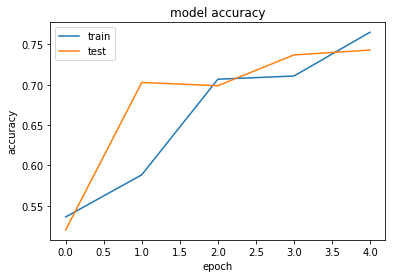

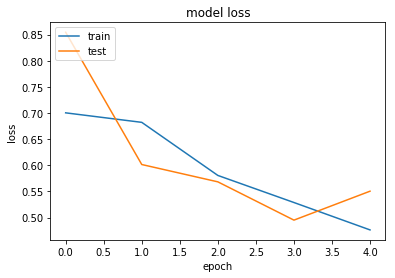

[[61 24]
 [ 3 82]]
accuracy :  0.8411764705882353
recall:  0.9647058823529412


In [12]:
test_seikai_label, x_test, Y_test, classes = keras_cnn_fit(loss, optimizer, batch, epoch, Y_test, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test)

### 誤分類した画像
- 青が正解：赤が予測値（０：癌でない, １：癌）

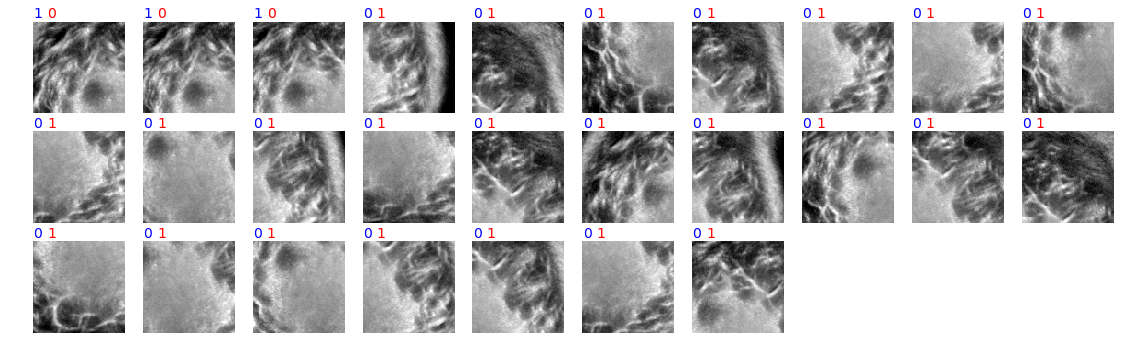

In [13]:
check_misclassification_image(test_seikai_label, x_test, Y_test, classes)

### UT003

In [16]:
#モデルのパラメータ
n_filter = 32
n_filter2 = 64
n_filter3 = 128

size_filter = 3
size_pool = 2
n_hidden = 512
n_label = 2

#コンパイル時のパラメータ
loss='categorical_crossentropy'
optimizer = "Adam"
batch = 64
epoch = 20

Y_test, X_train, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test = mk_data("UT003")

model = cnn_model (n_filter, n_filter2, n_filter3, size_filter, n_hidden, n_label, X_train)

Train on 464 samples, validate on 464 samples
Epoch 1/20
464/464 [==============================] - 60s 128ms/step - loss: 0.6991 - acc: 0.4914 - val_loss: 0.7242 - val_acc: 0.5086
Epoch 2/20
464/464 [==============================] - 56s 121ms/step - loss: 0.6782 - acc: 0.4978 - val_loss: 0.6421 - val_acc: 0.5819
Epoch 3/20
464/464 [==============================] - 61s 132ms/step - loss: 0.6033 - acc: 0.7198 - val_loss: 0.5571 - val_acc: 0.6961
Epoch 4/20
464/464 [==============================] - 61s 131ms/step - loss: 0.5600 - acc: 0.6983 - val_loss: 0.5463 - val_acc: 0.6918
Epoch 5/20
464/464 [==============================] - 57s 123ms/step - loss: 0.5314 - acc: 0.7414 - val_loss: 0.5035 - val_acc: 0.7478
Epoch 6/20
464/464 [==============================] - 57s 123ms/step - loss: 0.4757 - acc: 0.7780 - val_loss: 0.9900 - val_acc: 0.5323
Test loss: 4.341358315148743
Test accuracy: 0.5


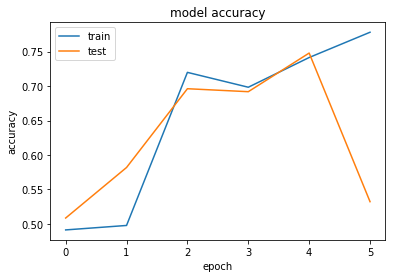

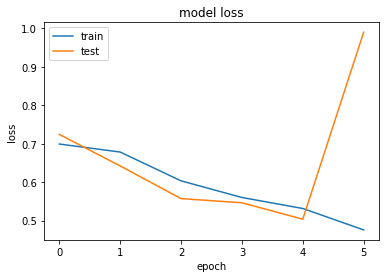

[[119   0]
 [119   0]]
accuracy :  0.5
recall:  0.0


In [17]:
test_seikai_label, x_test, Y_test, classes = keras_cnn_fit(loss, optimizer, batch, epoch, Y_test, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test)

ValueError: num must be 1 <= num <= 100, not 101

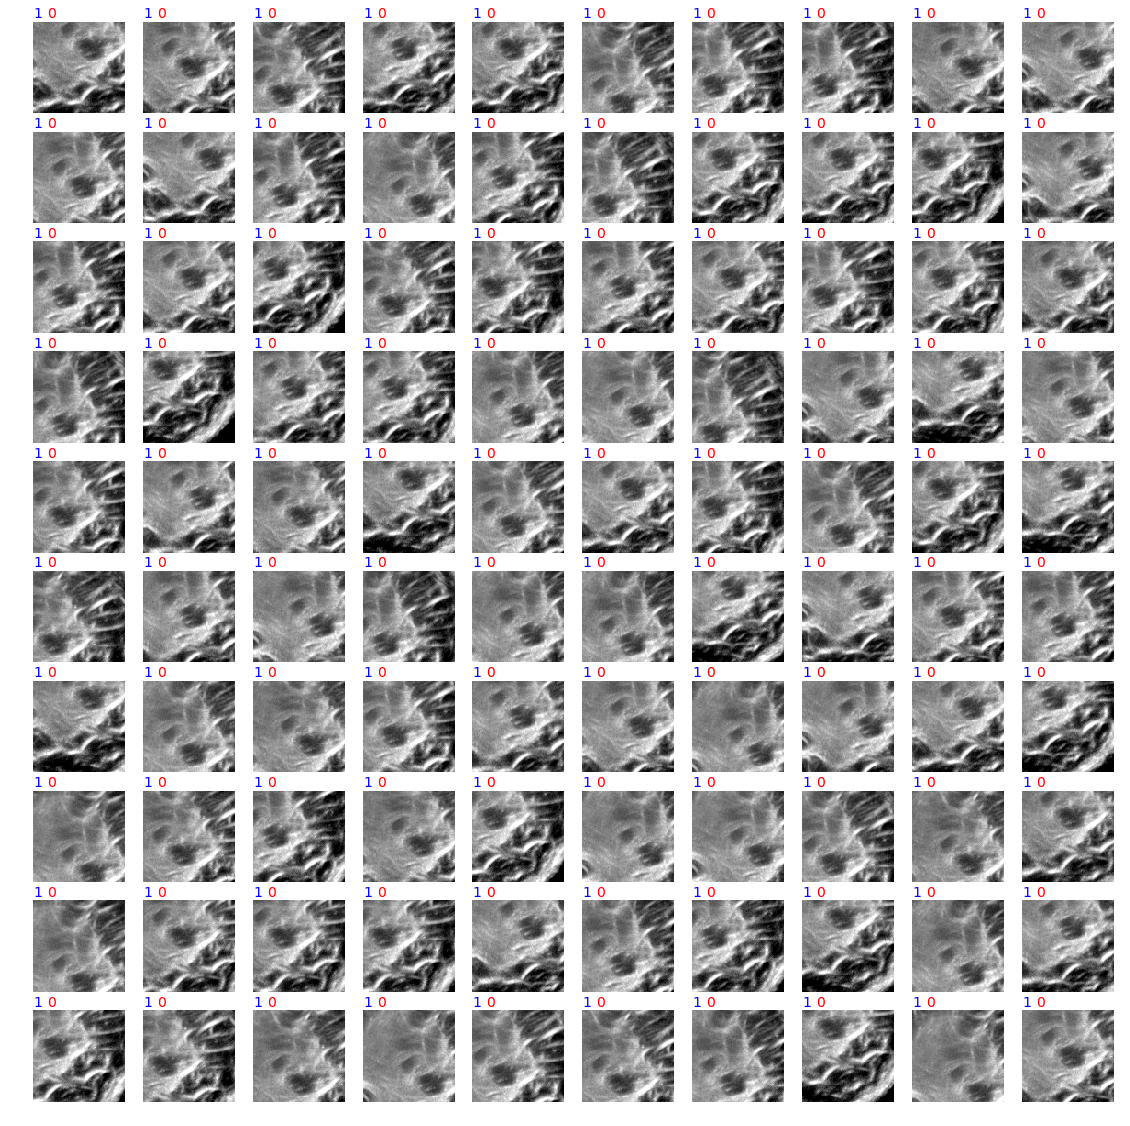

In [19]:
check_misclassification_image(test_seikai_label, x_test, Y_test, classes)

### UT007

In [20]:
#モデルのパラメータ
n_filter = 32
n_filter2 = 64
n_filter3 = 128

size_filter = 3
size_pool = 2
n_hidden = 512
n_label = 2

#コンパイル時のパラメータ
loss='categorical_crossentropy'
optimizer = "Adam"
batch = 64
epoch = 20

Y_test, X_train, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test = mk_data("UT007")

model = cnn_model (n_filter, n_filter2, n_filter3, size_filter, n_hidden, n_label, X_train)

Train on 537 samples, validate on 537 samples
Epoch 1/20
537/537 [==============================] - 67s 124ms/step - loss: 0.7126 - acc: 0.5196 - val_loss: 0.6860 - val_acc: 0.4935
Epoch 2/20
537/537 [==============================] - 69s 129ms/step - loss: 0.6500 - acc: 0.5903 - val_loss: 0.5619 - val_acc: 0.7263
Epoch 3/20
537/537 [==============================] - 68s 126ms/step - loss: 0.5569 - acc: 0.7151 - val_loss: 0.4981 - val_acc: 0.7616
Epoch 4/20
537/537 [==============================] - 80s 149ms/step - loss: 0.4885 - acc: 0.7505 - val_loss: 0.4803 - val_acc: 0.7728
Epoch 5/20
537/537 [==============================] - 73s 136ms/step - loss: 0.4688 - acc: 0.7616 - val_loss: 0.4728 - val_acc: 0.7784
Epoch 6/20
537/537 [==============================] - 64s 118ms/step - loss: 0.4360 - acc: 0.7896 - val_loss: 0.4808 - val_acc: 0.7747
Test loss: 0.588654030924258
Test accuracy: 0.6630434756693633


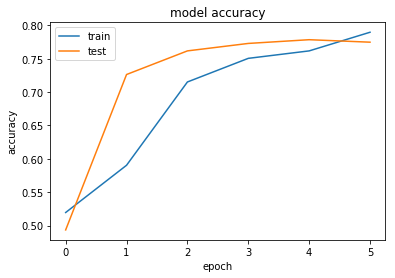

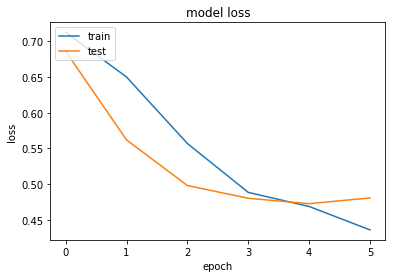

[[18 28]
 [ 3 43]]
accuracy :  0.6630434782608695
recall:  0.9347826086956522


In [21]:
test_seikai_label, x_test, Y_test, classes = keras_cnn_fit(loss, optimizer, batch, epoch, Y_test, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test)

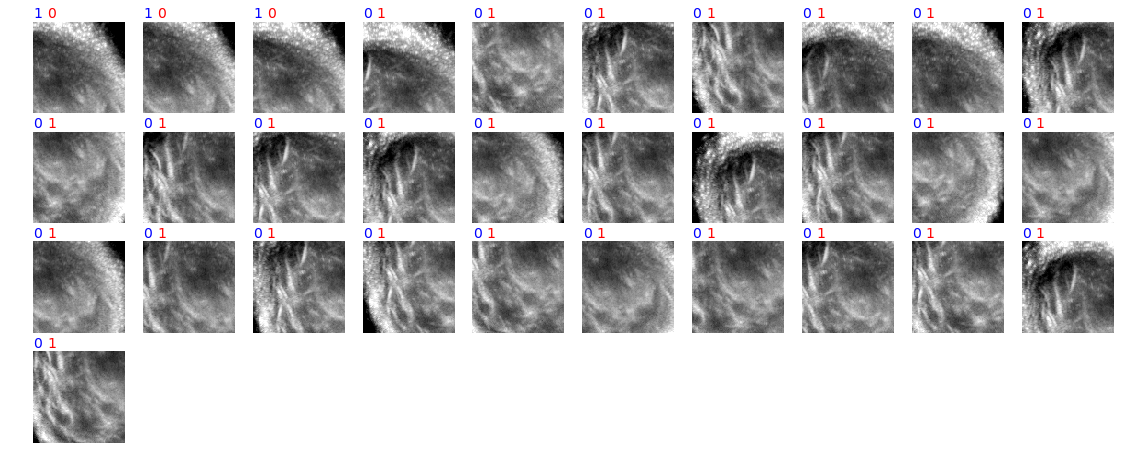

In [22]:
check_misclassification_image(test_seikai_label, x_test, Y_test, classes)

### UT008

In [23]:
#モデルのパラメータ
n_filter = 32
n_filter2 = 64
n_filter3 = 128

size_filter = 3
size_pool = 2
n_hidden = 512
n_label = 2

#コンパイル時のパラメータ
loss='categorical_crossentropy'
optimizer = "Adam"
batch = 64
epoch = 20

Y_test, X_train, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test = mk_data("UT008")

model = cnn_model (n_filter, n_filter2, n_filter3, size_filter, n_hidden, n_label, X_train)

Train on 499 samples, validate on 499 samples
Epoch 1/20
499/499 [==============================] - 62s 125ms/step - loss: 0.7132 - acc: 0.4850 - val_loss: 0.6773 - val_acc: 0.5190
Epoch 2/20
499/499 [==============================] - 60s 119ms/step - loss: 0.6406 - acc: 0.5912 - val_loss: 0.5830 - val_acc: 0.7114
Epoch 3/20
499/499 [==============================] - 58s 117ms/step - loss: 0.5697 - acc: 0.7194 - val_loss: 0.5557 - val_acc: 0.6874
Epoch 4/20
499/499 [==============================] - 59s 117ms/step - loss: 0.5044 - acc: 0.7575 - val_loss: 0.5063 - val_acc: 0.7335
Epoch 5/20
499/499 [==============================] - 61s 123ms/step - loss: 0.4876 - acc: 0.7776 - val_loss: 0.4714 - val_acc: 0.7715
Epoch 6/20
499/499 [==============================] - 60s 120ms/step - loss: 0.4483 - acc: 0.8016 - val_loss: 0.4731 - val_acc: 0.7756
Test loss: 0.5593814707937694
Test accuracy: 0.6726190476190477


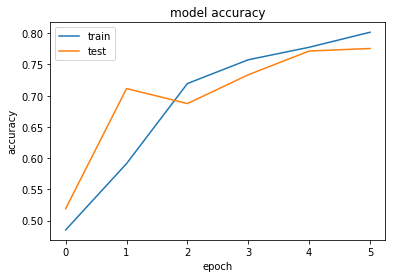

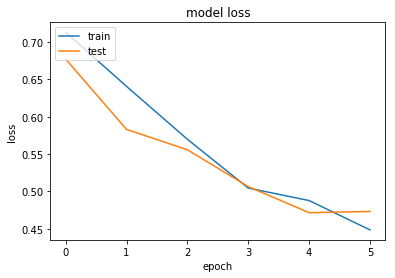

[[29 55]
 [ 0 84]]
accuracy :  0.6726190476190477
recall:  1.0


In [24]:
test_seikai_label, x_test, Y_test, classes = keras_cnn_fit(loss, optimizer, batch, epoch, Y_test, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test)

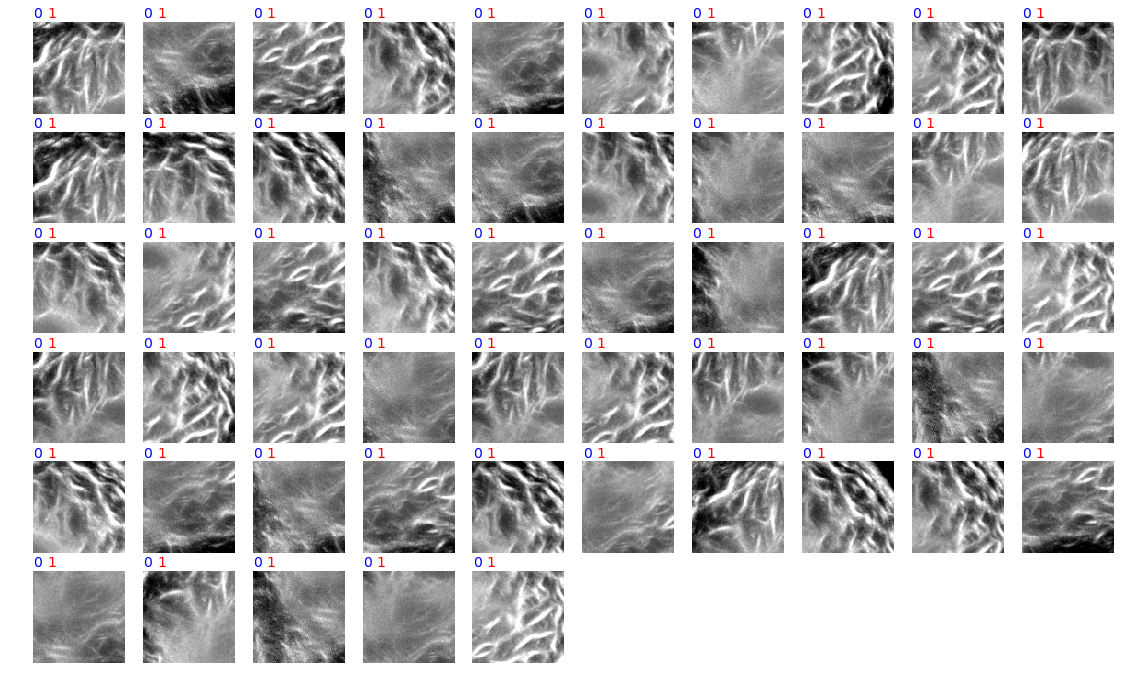

In [25]:
check_misclassification_image(test_seikai_label, x_test, Y_test, classes)

### UT009

In [28]:
#モデルのパラメータ
n_filter = 32
n_filter2 = 64
n_filter3 = 128

size_filter = 3
size_pool = 2
n_hidden = 512
n_label = 2

#コンパイル時のパラメータ
loss='categorical_crossentropy'
optimizer = "Adam"
batch = 64
epoch = 20

Y_test, X_train, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test = mk_data("UT009")

model = cnn_model (n_filter, n_filter2, n_filter3, size_filter, n_hidden, n_label, X_train)

Train on 528 samples, validate on 528 samples
Epoch 1/20
528/528 [==============================] - 64s 121ms/step - loss: 0.6863 - acc: 0.5473 - val_loss: 0.6100 - val_acc: 0.4886
Epoch 2/20
528/528 [==============================] - 68s 128ms/step - loss: 0.7067 - acc: 0.5985 - val_loss: 0.6840 - val_acc: 0.5246
Test loss: 0.6913622877814553
Test accuracy: 0.5090909094973044


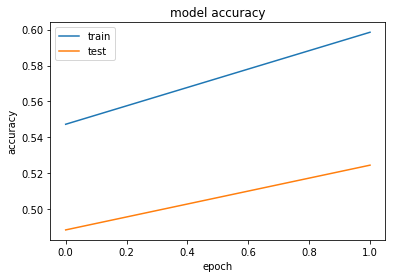

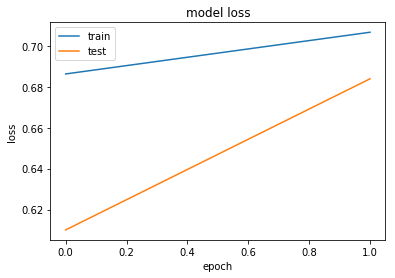

[[ 1 54]
 [ 0 55]]
accuracy :  0.509090909090909
recall:  1.0


In [29]:
test_seikai_label, x_test, Y_test, classes = keras_cnn_fit(loss, optimizer, batch, epoch, Y_test, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test)

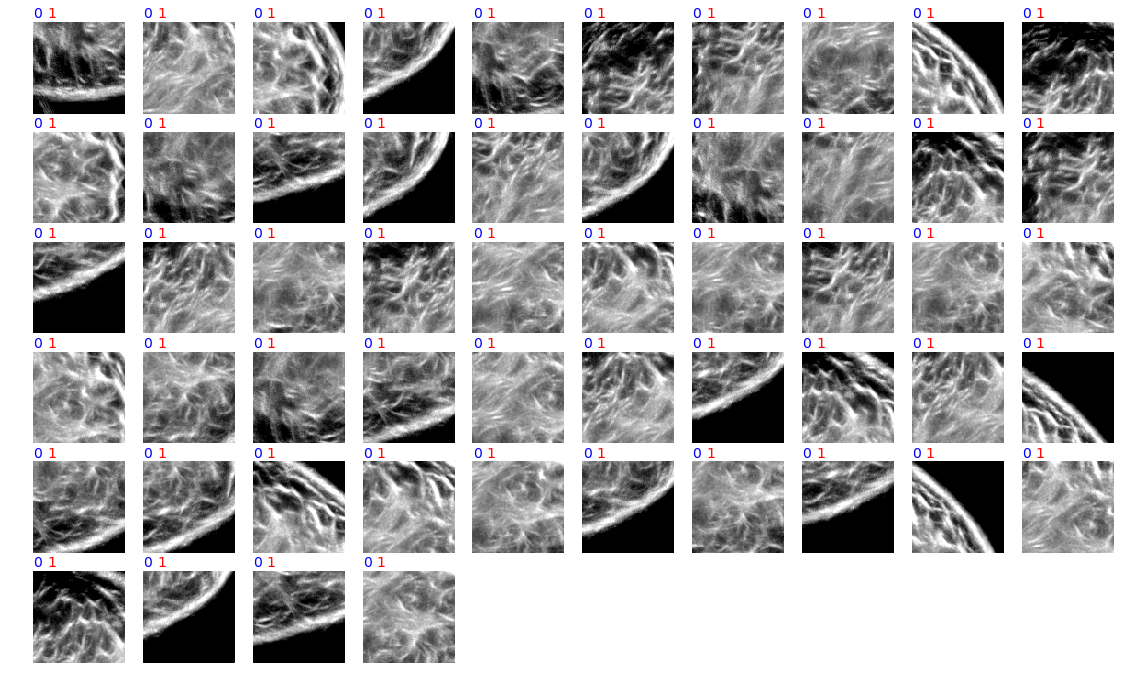

In [30]:
check_misclassification_image(test_seikai_label, x_test, Y_test, classes)

### UT010

In [31]:
#モデルのパラメータ
n_filter = 32
n_filter2 = 64
n_filter3 = 128

size_filter = 3
size_pool = 2
n_hidden = 512
n_label = 2

#コンパイル時のパラメータ
loss='categorical_crossentropy'
optimizer = "Adam"
batch = 64
epoch = 20

Y_test, X_train, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test = mk_data("UT010")

model = cnn_model (n_filter, n_filter2, n_filter3, size_filter, n_hidden, n_label, X_train)

Train on 475 samples, validate on 475 samples
Epoch 1/20
475/475 [==============================] - 71s 149ms/step - loss: 0.6920 - acc: 0.5411 - val_loss: 0.6002 - val_acc: 0.5116
Epoch 2/20
475/475 [==============================] - 68s 144ms/step - loss: 0.5523 - acc: 0.6400 - val_loss: 0.5807 - val_acc: 0.6632
Epoch 3/20
475/475 [==============================] - 65s 137ms/step - loss: 0.5393 - acc: 0.7242 - val_loss: 0.6528 - val_acc: 0.7074
Test loss: 4.768369319814223
Test accuracy: 0.4629629607553835


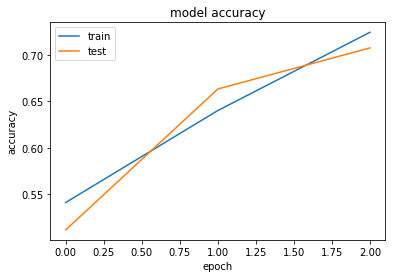

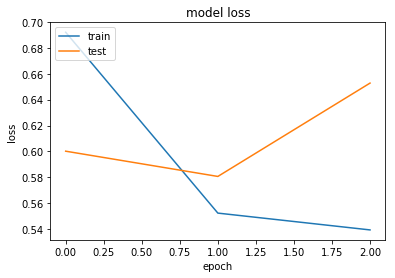

[[ 98  10]
 [106   2]]
accuracy :  0.46296296296296297
recall:  0.018518518518518517


In [32]:
test_seikai_label, x_test, Y_test, classes = keras_cnn_fit(loss, optimizer, batch, epoch, Y_test, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test)

ValueError: num must be 1 <= num <= 100, not 101

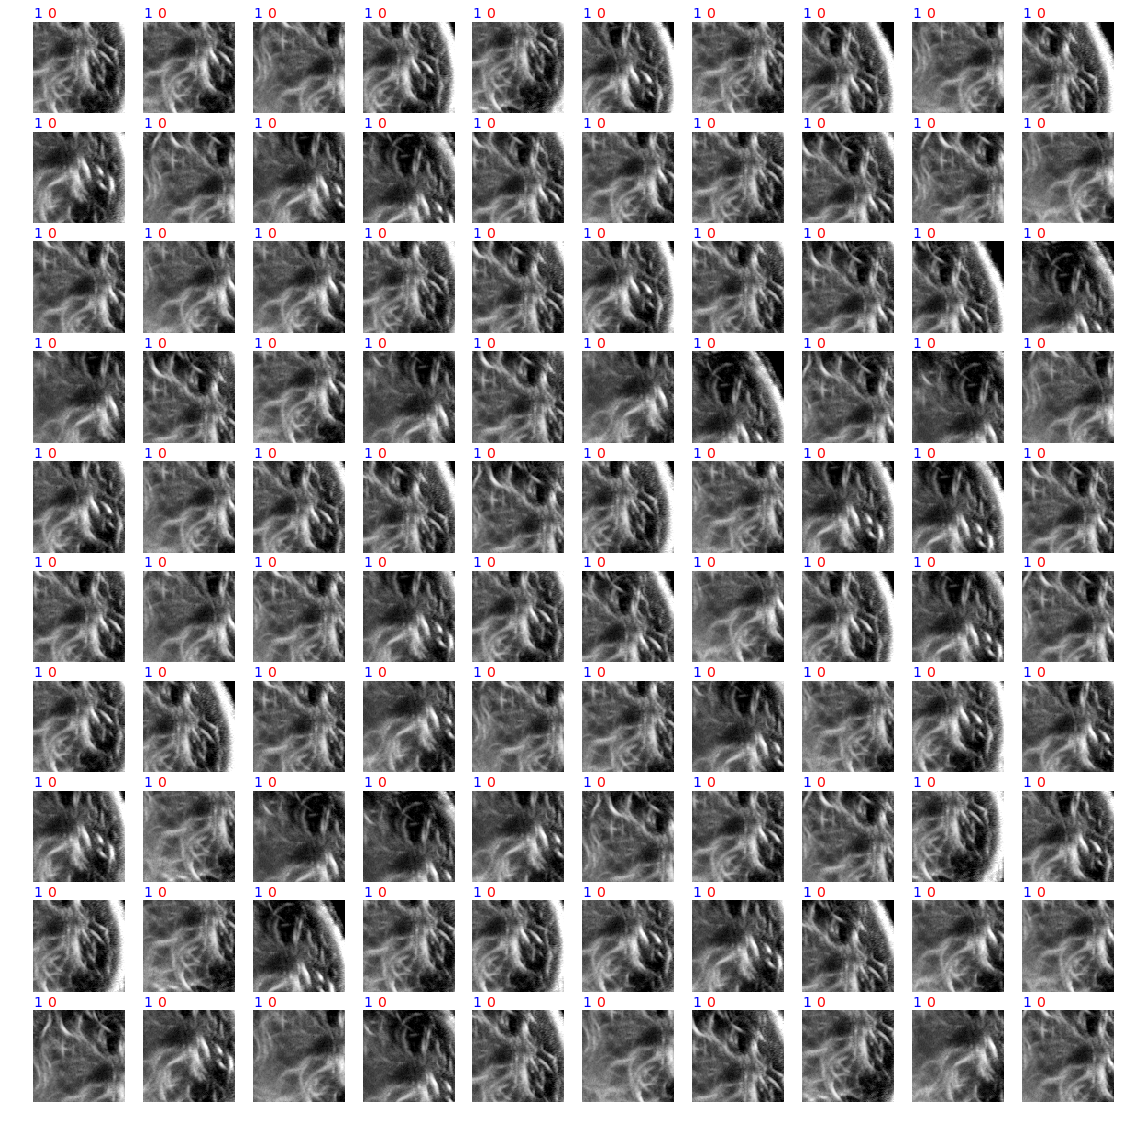

In [33]:
check_misclassification_image(test_seikai_label, x_test, Y_test, classes)

### UT011

In [34]:
#モデルのパラメータ
n_filter = 32
n_filter2 = 64
n_filter3 = 128

size_filter = 3
size_pool = 2
n_hidden = 512
n_label = 2

#コンパイル時のパラメータ
loss='categorical_crossentropy'
optimizer = "Adam"
batch = 64
epoch = 20

Y_test, X_train, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test = mk_data("UT011")

model = cnn_model (n_filter, n_filter2, n_filter3, size_filter, n_hidden, n_label, X_train)

Train on 497 samples, validate on 497 samples
Epoch 1/20
497/497 [==============================] - 64s 128ms/step - loss: 0.7014 - acc: 0.5070 - val_loss: 0.6247 - val_acc: 0.5292
Epoch 2/20
497/497 [==============================] - 70s 141ms/step - loss: 0.6087 - acc: 0.6761 - val_loss: 0.5506 - val_acc: 0.7324
Epoch 3/20
497/497 [==============================] - 66s 132ms/step - loss: 0.5415 - acc: 0.7565 - val_loss: 0.5349 - val_acc: 0.7062
Epoch 4/20
497/497 [==============================] - 69s 138ms/step - loss: 0.5443 - acc: 0.7304 - val_loss: 0.5457 - val_acc: 0.6922
Test loss: 0.6660775528397671
Test accuracy: 0.5697674422070037


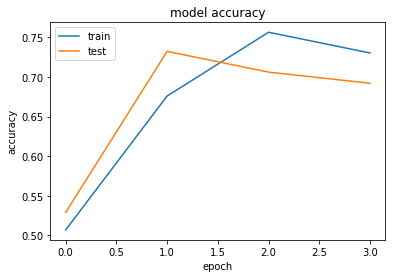

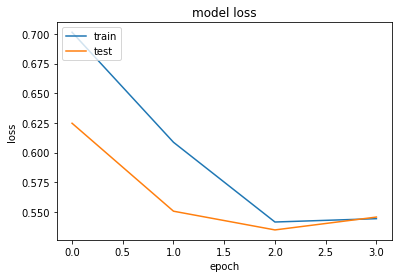

[[14 72]
 [ 2 84]]
accuracy :  0.5697674418604651
recall:  0.9767441860465116


In [35]:
test_seikai_label, x_test, Y_test, classes = keras_cnn_fit(loss, optimizer, batch, epoch, Y_test, x_test, y_test, val_x_train, val_y_train, val_x_test, val_y_test)

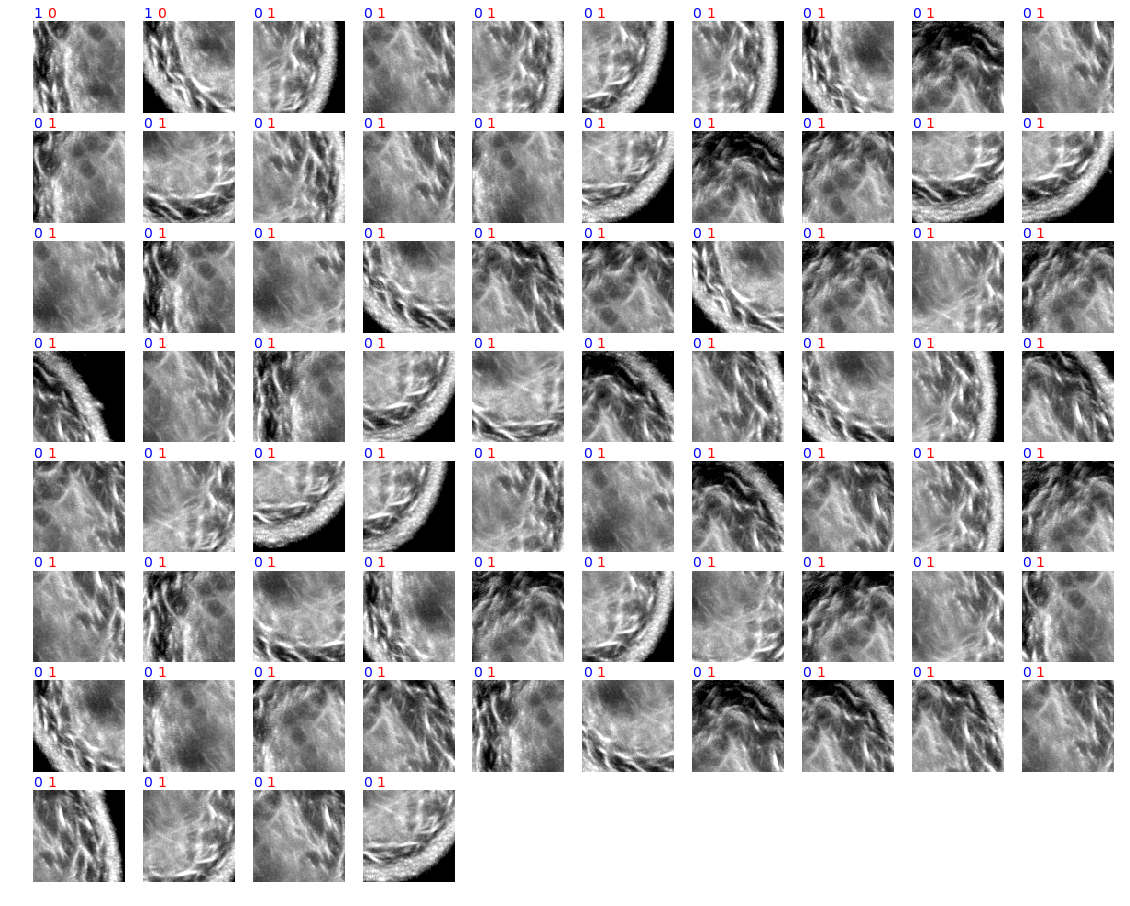

In [36]:
check_misclassification_image(test_seikai_label, x_test, Y_test, classes)

### 現状の問題点
- epochをうまく回せないと、学習できずに終わってしまう。
- ただし, early_stoppingを使わないと, 過学習が起きてしまう・・・
